In [52]:
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
from scipy import integrate

In [53]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [54]:
lats = np.linspace(90, -90, 121)
lons = np.linspace(0, 358.5, 240)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400,
          450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

In [55]:
### Onetime change to make all vertical dimensions be levelist

#years = np.arange(2011, 2019, 1)

#for year in years:
    #ds_orig = xr.open_dataset(f'monthly_data/ds_{year}_old.nc')
    
    #ds_new = ds_orig.rename({'level':'levelist'})
    
    #ds_new.to_netcdf(f'ds_{year}.nc')

In [56]:
raw_data = xr.open_mfdataset('monthly_data/ds_*.nc')

#Let's only select through 2021, the last full year
raw_data = raw_data#.sel(time=slice('1980-01-01', '2021-12-31'))

#Through 2013
ps_data1 = xr.open_dataset('monthly_data/2dfields.nc').sp

#2014 through 2018
ps_data2 = xr.open_mfdataset('monthly_data/*_ps.nc').sp

ps_full = xr.concat([ps_data1, ps_data2], dim='time')

In [66]:
raw_data

,Array,Chunk
Bytes,1.92 GiB,49.19 MiB
Shape,"(480, 37, 121, 240)","(12, 37, 121, 240)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.92 GiB,49.19 MiB
Shape,"(480, 37, 121, 240)","(12, 37, 121, 240)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


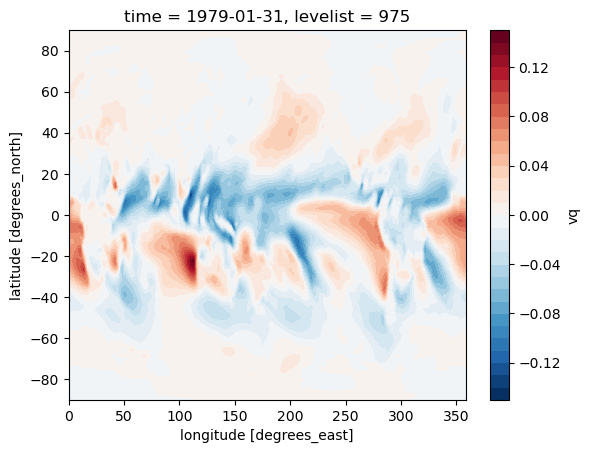

In [69]:
raw_data.vq.isel(time=0).isel(levelist=-2).plot.contourf(levels=30)

plt.show()

In [6]:
#First get the weights

levels_array = np.array(levels)
mlev = (levels_array[:-1] + levels_array[1:]) / 2
new_mlev = np.append(np.insert(mlev, 0, 0), 1000)
#Now we have the generic edges of our level boxes

WEIGHT = np.empty((len(levels), len(lats), len(lons)))
ps = ps_full.mean('time').values / 100 #To get in hPa

for i in range(len(lats)):
    for j in range(len(lons)):
        
        #This looks and first makes sure that the level at each point is not below the surface pressure
        #If a point is below ths surface pressure, it gets converted to the surface pressure
        #Then we subtract out the original neighboring levels
        #This will result in some level boxes getting negative weight (where surface pressure was used)
        #So, we change those values to 0
        #Then we deal with converting hPa to Pa and making units work with g
        WEIGHT[:,i,j] = np.maximum(np.minimum(new_mlev[1:], ps[i,j] * np.ones(len(levels))) - new_mlev[:-1],
                                   np.zeros(len(levels))) * 100 / g

#This is our generic weighting, used later
weight = (new_mlev[:-1] - new_mlev[1:]) * 100 / g

In [7]:
#This is basically just making a topography maks

tmask = np.ones((len(levels), len(lats), len(lons)))
TMASK = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        lon_idxs = np.where(ps[j,:] < new_mlev[i+1])

        tmask[i,j,lon_idxs] = 0
        TMASK[i,j,lon_idxs] = np.nan

In [8]:
#This is the weighting for each point, allowing for us to take zonal averages more easily

ZON_NORM = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        ZON_NORM[i,j,:] = WEIGHT[i,j,:] / np.maximum(np.sum(WEIGHT[i,j,:]), 1e-5)

In [9]:
#And zonal weights, useful for AHT where we have zonal-mean quantities

ZON_WEIGHT = np.ones((len(levels), len(lats)))

for i in range(len(levels)):
    ZON_WEIGHT[i,:] = np.mean(WEIGHT[i,:,:], axis=1)

### Now, let's save out all the weighting info to a netcdf

In [10]:
WEIGHT_attrs = 'Weighting for each grid cell. Not normalized.'
weight_attrs = 'Generic weighting for the column. Does not account for surface pressure.'
TMASK_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or nan if below. Unitless.'
tmask_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or 0 if below. Unitless.'
ZON_NORM_attrs = 'Basically a normalized version of WEIGHT, where the normalization is over longitude. To take a zonal average, multiply a quantity by this and sum along the longitude dimenion. Unitless.'
ZON_WEIGHT_attrs = 'Zonal average weight.'

weighting_ds = xr.Dataset(
                    data_vars = dict(
                        WEIGHT=(['level','latitude','longitude'], WEIGHT, {'Description':WEIGHT_attrs, 'units':'kg/m^2'}),
                        weight=(['level'], weight, {'Description':weight_attrs, 'units':'kg/m^2'}),
                        TMASK=(['level','latitude','longitude'], TMASK, {'Description':TMASK_attrs, 'units':'Unitless'}),
                        tmask=(['level','latitude','longitude'], tmask, {'Description':tmask_attrs, 'units':'Unitless'}),
                        ZON_NORM=(['level','latitude','longitude'], ZON_NORM, {'Description':ZON_NORM_attrs, 'units':'Unitless'}),
                        ZON_WEIGHT=(['level','latitude'], ZON_WEIGHT, {'Description':ZON_WEIGHT_attrs, 'units':'kg/m^2'}),
                    ),
                    coords=dict(
                        level=levels[::-1],
                        latitude=lats,
                        longitude=lons)
)

#weighting_ds.to_netcdf('era_interim_aht_weights.nc')

### Then let's find the near-surface MSE, which we'll later add to the AHT ds

In [11]:
raw_data['mse_surf'] = raw_data.t*cp + raw_data.q*L

In [12]:
mse_zonal = np.sum(raw_data.mse_surf * ZON_NORM[None,:,:,:], axis=3)

In [13]:
mse_zonal_values = mse_zonal.values

In [14]:
ZON_WEIGHT_normed = ZON_WEIGHT / np.amax(ZON_WEIGHT,axis=1)[:,None]

#Basically saying we need data for half the points at a lat/height to not nan it
ZON_WEIGHT_normed[ZON_WEIGHT_normed < 0.5] = np.nan

bottom_idxs = len(levels) - (~np.isnan(ZON_WEIGHT_normed)).cumsum(0).argmax(0)

In [15]:
mse_surf = np.zeros((len(raw_data.time),len(lats)))

for i in range(len(lats)):
    mse_surf[:,i] = mse_zonal_values[:,len(levels) - bottom_idxs[i],i]

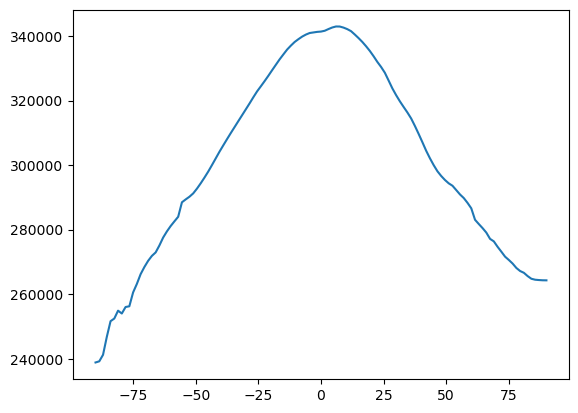

In [16]:
plt.plot(lats, np.mean(mse_surf, axis=0))

plt.show()

### Now calculate AHT

In [17]:
def aht_era_interim(time_idx, correct_mass=True):
    
    #For consistency, we will extrapolate all datasets beneath the surface
    #Can specify different interpolation/extrapolation methods if desired
    #It shouldn't really matter which method is chosen
    #Load in the data and flip the level dimension, since we did this for the weighting too
    extrap_method='linear'
    v = raw_data.v.isel(time=time_idx).values
    t = raw_data.t.isel(time=time_idx).values
    q = raw_data.q.isel(time=time_idx).values
    z = raw_data.z.isel(time=time_idx).values
    
    vt = raw_data.vt.isel(time=time_idx).values
    vq = raw_data.vq.isel(time=time_idx).values
    vz = raw_data.vz.isel(time=time_idx).values


    #Now get rid of nans everywhere
    WEIGHT[np.isnan(v)] = 0
    WEIGHT[np.isnan(t)] = 0
    WEIGHT[np.isnan(q)] = 0
    WEIGHT[np.isnan(z)] = 0

    v[np.isnan(v)] = 0
    t[np.isnan(t)] = 0
    q[np.isnan(q)] = 0
    z[np.isnan(z)] = 0
    vt[np.isnan(vt)] = 0
    vq[np.isnan(vq)] = 0
    vz[np.isnan(vz)] = 0

    #Convert everything to the same MSE units
    SE = cp * t
    PE = z #Should already be in MSE units
    ME = L * q
    MSE = SE + PE + ME
    
    #Find zonal-averages
    SE_bar = np.sum(ZON_NORM * SE, axis=2)
    ME_bar = np.sum(ZON_NORM * ME, axis=2)
    PE_bar = np.sum(ZON_NORM * PE, axis=2)
    V_bar = np.sum(ZON_NORM * v, axis=2)
    E_bar = np.sum(ZON_NORM * MSE, axis=2)

    #Then find zonal anomalies
    Ve = v - V_bar[:,:,None]
    SEe = SE - SE_bar[:,:,None]
    MEe = ME - ME_bar[:,:,None]
    PEe = PE - PE_bar[:,:,None]
    
    #Multiply zonal-anomalies to get the SE piece
    #_map is just referring to plan view, ie before zonal averaging occurs
    #Dividing the WEIGHT by weight, normalizes things
    VSEse_map = (Ve * SEe) * (WEIGHT / weight[:,None,None])
    VMEse_map = (Ve * MEe) * (WEIGHT / weight[:,None,None])
    VPEse_map = (Ve * PEe) * (WEIGHT / weight[:,None,None])
    
    #Get the SEs
    VSEse_bar = np.mean(VSEse_map, axis=2)
    VMEse_bar = np.mean(VMEse_map, axis=2)
    VPEse_bar = np.mean(VPEse_map, axis=2)
    
    #Now do the TEs
    #Magically, MERRA2 outputs vt, vq, and vz, just the way we want them (with means removed)
    #So, follow same formula as SEs     
    VSEte_map = ((vt * cp) - (v * SE)) * (WEIGHT / weight[:,None,None])
    VMEte_map = ((vq * L) - (v * ME)) * (WEIGHT / weight[:,None,None])
    VPEte_map = ((vz) - (v * PE)) * (WEIGHT / weight[:,None,None])

    VSEte_bar = np.mean(VSEte_map, axis=2)
    VMEte_bar = np.mean(VMEte_map, axis=2)
    VPEte_bar = np.mean(VPEte_map, axis=2)
        
    #Account for non-zero mass transport in the MMC by removing the vertically averaged v and MSE
    V_vert_ave = np.sum(V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    E_vert_ave = np.sum(E_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    ME_vert_ave = np.sum(ME_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    PE_vert_ave = np.sum(PE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    SE_vert_ave = np.sum(SE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    
    if correct_mass == True:
        V_bar_new = V_bar - V_vert_ave[None,:]
        E_bar_new = E_bar - E_vert_ave[None,:]
        ME_bar_new = ME_bar - ME_vert_ave[None,:]
        PE_bar_new = PE_bar - PE_vert_ave[None,:]
        SE_bar_new = SE_bar - SE_vert_ave[None,:]
    elif correct_mass == False:
        V_bar_new = V_bar
        E_bar_new = E_bar
        ME_bar_new = ME_bar
        PE_bar_new = PE_bar
        SE_bar_new = SE_bar
    else:
        print('Error with specifying mass correction choice')
        
    #MASS = np.sum(ZON_WEIGHT * V_bar * E_vert_ave[None,:], axis=0)
    MASS = np.sum(ZON_WEIGHT, axis=0) * V_vert_ave * E_vert_ave

    #Now multiply things by the needed weights and sum in the vertical
    MMC = np.sum(ZON_WEIGHT * V_bar_new * E_bar_new, axis=0)
    strm_fnct = np.cumsum((ZON_WEIGHT * V_bar_new), axis=0)
    MMC_moist = np.sum(ZON_WEIGHT * V_bar_new * ME_bar_new, axis=0)
    MMC_dry = np.sum(ZON_WEIGHT * V_bar_new * SE_bar_new, axis=0)
    MMC_pot = np.sum(ZON_WEIGHT * V_bar_new * PE_bar_new, axis=0)
    
    #MASS_new = np.sum(ZON_WEIGHT * V_bar_new * E_vert_ave[None,:], axis=0)
    
    #SEs and TEs have already accounted for surface orography, so we just use generic weight here
    SE_dry = np.sum(weight[:,None] * VSEse_bar, axis=0)
    SE_pot = np.sum(weight[:,None] * VPEse_bar, axis=0)
    SE_moist = np.sum(weight[:,None] * VMEse_bar, axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = np.sum(weight[:,None] * VSEte_bar, axis=0)
    TE_pot = np.sum(weight[:,None] * VPEte_bar, axis=0)
    TE_moist = np.sum(weight[:,None] * VMEte_bar, axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    return MMC, MMC_moist, MMC_dry, MMC_pot, SE, SE_moist, SE_dry, SE_pot, TE, TE_moist, TE_dry, TE_pot, MASS, strm_fnct, VSEse_bar, VPEse_bar, VMEse_bar, VSEte_bar, VPEte_bar, VMEte_bar, E_bar_new, V_bar_new, SE_bar_new, PE_bar_new, ME_bar_new



In [18]:
num_months = len(raw_data.time)

TEs = np.zeros((num_months, len(lats)))
TEs_moist = np.zeros((num_months, len(lats)))
TEs_dry = np.zeros((num_months, len(lats)))
TEs_pot = np.zeros((num_months, len(lats)))
SEs = np.zeros((num_months, len(lats)))
SEs_moist = np.zeros((num_months, len(lats)))
SEs_dry = np.zeros((num_months, len(lats)))
SEs_pot = np.zeros((num_months, len(lats)))
MMCs = np.zeros((num_months, len(lats)))
MMCs_moist = np.zeros((num_months, len(lats)))
MMCs_dry = np.zeros((num_months, len(lats)))
MMCs_pot = np.zeros((num_months, len(lats)))
MASS_fluxes = np.zeros((num_months, len(lats)))
strm_fncts = np.zeros((num_months, len(levels), len(lats)))
VSEses = np.zeros((num_months, len(levels), len(lats)))
VPEses = np.zeros((num_months, len(levels), len(lats)))
VMEses = np.zeros((num_months, len(levels), len(lats)))
VSEtes = np.zeros((num_months, len(levels), len(lats)))
VPEtes = np.zeros((num_months, len(levels), len(lats)))
VMEtes = np.zeros((num_months, len(levels), len(lats)))
V_bars = np.zeros((num_months, len(levels), len(lats)))
E_bars = np.zeros((num_months, len(levels), len(lats)))
SE_bars = np.zeros((num_months, len(levels), len(lats)))
PE_bars = np.zeros((num_months, len(levels), len(lats)))
ME_bars = np.zeros((num_months, len(levels), len(lats)))

for i in range(num_months):
    values = aht_era_interim(i)
    MMCs[i,:] = values[0]
    MMCs_moist[i,:] = values[1]
    MMCs_dry[i,:] = values[2]
    MMCs_pot[i,:] = values[3]
    
    SEs[i,:] = values[4]
    SEs_moist[i,:] = values[5]
    SEs_dry[i,:] = values[6]
    SEs_pot[i,:] = values[7]
    
    TEs[i,:] = values[8]
    TEs_moist[i,:] = values[9]
    TEs_dry[i,:] = values[10]
    TEs_pot[i,:] = values[11]
    
    MASS_fluxes[i,:] = values[12]
    
    strm_fncts[i,:,:] = values[13]
    
    VSEses[i,:,:] = values[14]
    VPEses[i,:,:] = values[15]
    VMEses[i,:,:] = values[16]
    
    VSEtes[i,:,:] = values[17]
    VPEtes[i,:,:] = values[18]
    VMEtes[i,:,:] = values[19]
    
    V_bars[i,:,:] = values[20]
    E_bars[i,:,:] = values[21]
    SE_bars[i,:,:] = values[22]
    PE_bars[i,:,:] = values[23]
    ME_bars[i,:,:] = values[24]

In [19]:
TOTs = MMCs + SEs + TEs
TOTs_moist = MMCs_moist + SEs_moist + TEs_moist
TOTs_dry = MMCs_dry + SEs_dry + TEs_dry
TOTs_pot = MMCs_pot + SEs_pot + TEs_pot
TOTs_dry_pot = TOTs_dry + TOTs_pot

TEs_dry_pot = TEs_dry + TEs_pot
SEs_dry_pot = SEs_dry + SEs_pot
MMCs_dry_pot = MMCs_dry + MMCs_pot

EDDYs = SEs + TEs
EDDYs_moist = SEs_moist + TEs_moist
EDDYs_dry = SEs_dry + TEs_dry
EDDYs_pot = SEs_pot + TEs_pot
EDDYs_dry_pot = EDDYs_dry + EDDYs_pot

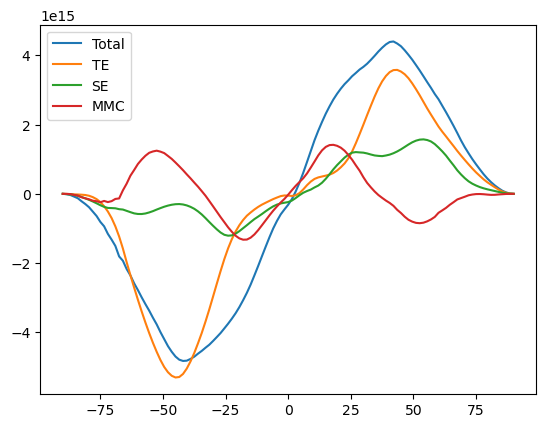

In [20]:
plt.plot(lats, np.mean(TOTs, axis=0)* (geometry * g), label='Total')
plt.plot(lats, np.mean(TEs, axis=0)* (geometry * g), label='TE')
plt.plot(lats, np.mean(SEs, axis=0)* (geometry * g), label='SE')
plt.plot(lats, np.mean(MMCs, axis=0)* (geometry * g), label='MMC')

plt.legend(loc=0)
plt.show()

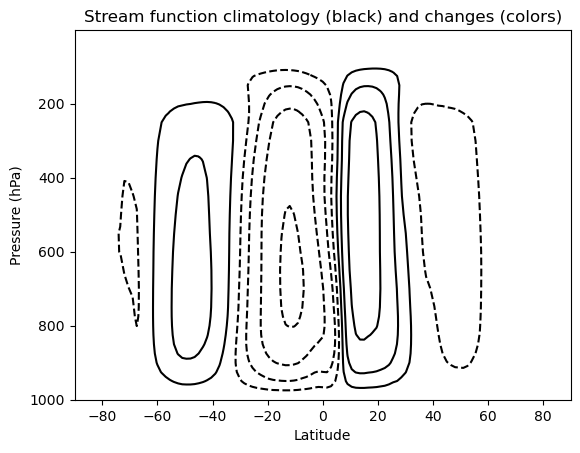

In [21]:
clima_strm = np.mean(strm_fncts, axis=0)* g * geometry[None,:]

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')


plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded


#plt.axhline(700)
#plt.axvline(-12)

#plt.xlim([-50, 50])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.title('Stream function climatology (black) and changes (colors)')

#plt.savefig('../figures/aht_trends/jra_stream_function_clima_and_changes')

plt.show()

In [51]:
vert_conversion =  -1000 / g

final_ds = xr.Dataset(
                    data_vars = dict(
                        total_aht=(['time','latitude'], TOTs * (geometry * g)[None,:]),
                        total_aht_dry=(['time','latitude'], TOTs_dry * (geometry * g)[None,:]),
                        total_aht_moist=(['time','latitude'], TOTs_moist * (geometry * g)[None,:]),
                        total_aht_pot=(['time','latitude'], TOTs_pot * (geometry * g)[None,:]),
                        total_aht_dry_pot=(['time','latitude'], TOTs_dry_pot * (geometry * g)[None,:]),
                        mmc_aht=(['time','latitude'], MMCs * (geometry * g)[None,:]),
                        mmc_aht_dry=(['time','latitude'], MMCs_dry * (geometry * g)[None,:]),
                        mmc_aht_moist=(['time','latitude'], MMCs_moist * (geometry * g)[None,:]),
                        mmc_aht_pot=(['time','latitude'], MMCs_pot * (geometry * g)[None,:]),
                        mmc_aht_dry_pot=(['time','latitude'], MMCs_dry_pot * (geometry * g)[None,:]),
                        se_aht=(['time','latitude'], SEs * (geometry * g)[None,:]),
                        se_aht_dry=(['time','latitude'], SEs_dry * (geometry * g)[None,:]),
                        se_aht_moist=(['time','latitude'], SEs_moist * (geometry * g)[None,:]),
                        se_aht_pot=(['time','latitude'], SEs_pot * (geometry * g)[None,:]),
                        se_aht_dry_pot=(['time','latitude'], SEs_dry_pot * (geometry * g)[None,:]),
                        te_aht=(['time','latitude'], TEs * (geometry * g)[None,:]),
                        te_aht_dry=(['time','latitude'], TEs_dry * (geometry * g)[None,:]),
                        te_aht_moist=(['time','latitude'], TEs_moist * (geometry * g)[None,:]),
                        te_aht_pot=(['time','latitude'], TEs_pot * (geometry * g)[None,:]),
                        te_aht_dry_pot=(['time','latitude'], TEs_dry_pot * (geometry * g)[None,:]),
                        eddy_aht=(['time','latitude'], EDDYs * (geometry * g)[None,:]),
                        eddy_aht_dry=(['time','latitude'], EDDYs_dry * (geometry * g)[None,:]),
                        eddy_aht_moist=(['time','latitude'], EDDYs_moist * (geometry * g)[None,:]),
                        eddy_aht_pot=(['time','latitude'], EDDYs_pot * (geometry * g)[None,:]),
                        eddy_aht_dry_pot=(['time','latitude'], EDDYs_dry_pot * (geometry * g)[None,:]),
                        mass=(['time','latitude'], MASS_fluxes * (geometry * g)[None,:]),
                        mse_surf=(['time','latitude'], mse_surf),
                        strm_fnct=(['time','level','latitude'], strm_fncts * g * geometry[None,None,:]),
                        VSEse=(['time','level','latitude'], VSEses * -1000 * g**2 * geometry[None,None,:]),
                        VPEse=(['time','level','latitude'], VPEses * -1000 * g**2 * geometry[None,None,:]),
                        VMEse=(['time','level','latitude'], VMEses * -1000 * g**2 * geometry[None,None,:]),
                        VSEte=(['time','level','latitude'], VSEtes * -1000 * g**2 * geometry[None,None,:]),
                        VPEte=(['time','level','latitude'], VPEtes * -1000 * g**2 * geometry[None,None,:]),
                        VMEte=(['time','level','latitude'], VMEtes * -1000 * g**2 * geometry[None,None,:]),
                        V_bar=(['time','level','latitude'], V_bars),
                        E_bar=(['time','level','latitude'], E_bars),
                        ME_bar=(['time','level','latitude'], ME_bars),
                        PE_bar=(['time','level','latitude'], PE_bars),
                        SE_bar=(['time','level','latitude'], SE_bars),
                    ),
                    coords=dict(
                        time=raw_data.time,
                        level=levels,
                        latitude=lats,)
)

#final_ds.to_netcdf('era_interim_aht.nc')

In [23]:
old_ds = xr.open_dataset('../aaron_aht_stuff/era_interim.nc')

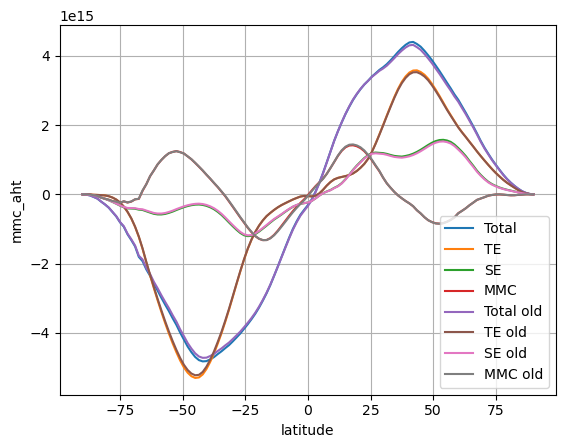

In [24]:
(final_ds.total_aht.mean('time')).plot(label='Total')
(final_ds.te_aht.mean('time')).plot(label='TE')
(final_ds.se_aht.mean('time')).plot(label='SE')
(final_ds.mmc_aht.mean('time')).plot(label='MMC')

(old_ds.total_aht.mean('time')).plot(label='Total old')
(old_ds.te_aht.mean('time')).plot(label='TE old')
(old_ds.se_aht.mean('time')).plot(label='SE old')
(old_ds.mmc_aht.mean('time')).plot(label='MMC old')

plt.grid()

plt.legend(loc=0)

plt.show()

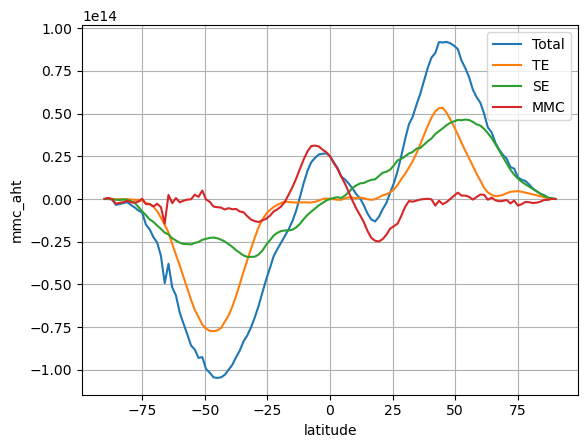

In [48]:
diff_ds = (final_ds - old_ds).sel(time=slice('2004-01-01', '2017-12-31'))

(diff_ds.total_aht.mean('time')).plot(label='Total')
(diff_ds.te_aht.mean('time')).plot(label='TE')
(diff_ds.se_aht.mean('time')).plot(label='SE')
(diff_ds.mmc_aht.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

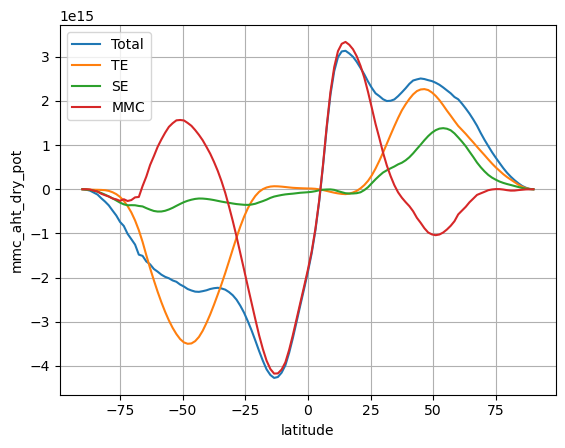

In [25]:
(final_ds.total_aht_dry_pot.mean('time')).plot(label='Total')
(final_ds.te_aht_dry_pot.mean('time')).plot(label='TE')
(final_ds.se_aht_dry_pot.mean('time')).plot(label='SE')
(final_ds.mmc_aht_dry_pot.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

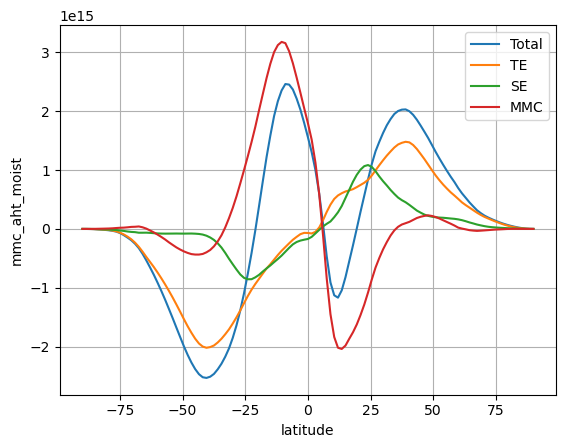

In [26]:
(final_ds.total_aht_moist.mean('time')).plot(label='Total')
(final_ds.te_aht_moist.mean('time')).plot(label='TE')
(final_ds.se_aht_moist.mean('time')).plot(label='SE')
(final_ds.mmc_aht_moist.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

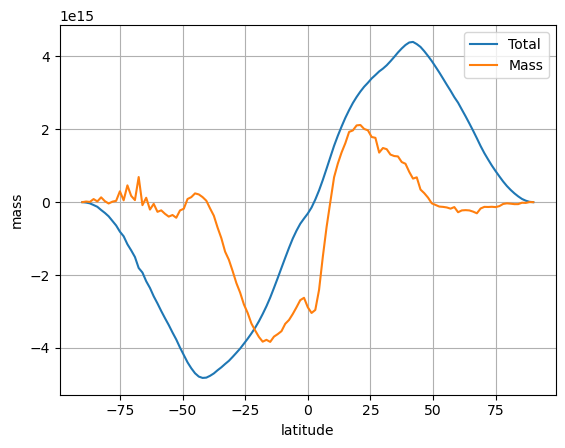

In [27]:
(final_ds.total_aht.mean('time')).plot(label='Total')
(final_ds.mass.mean('time')).plot(label='Mass')

plt.grid()

plt.legend(loc=0)

plt.show()

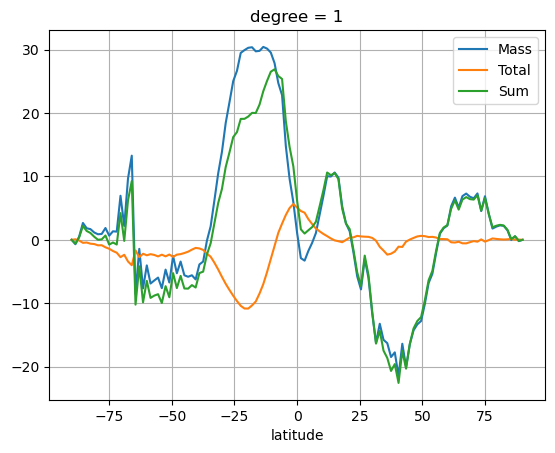

In [28]:
trends_ds = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
(trends_ds.mass_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Mass')
(trends_ds.total_aht_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Total')

((trends_ds.total_aht_polyfit_coefficients + trends_ds.mass_polyfit_coefficients).sel(degree=1) / 1e12).plot(label='Sum')
plt.legend(loc=0)
plt.grid()
plt.show()

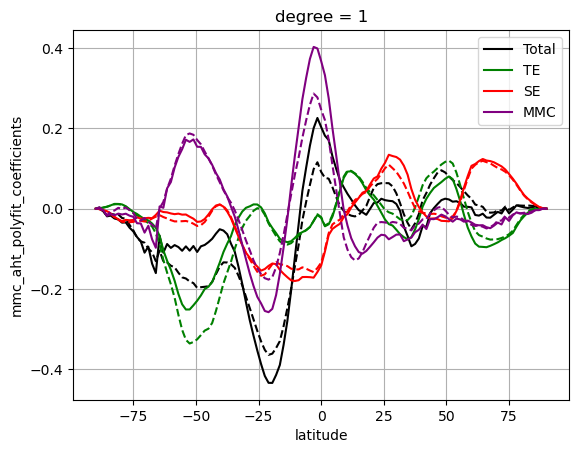

In [50]:
trends_ds = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
trends_ds_old = old_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
(trends_ds.total_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(color='k', label='Total')
(trends_ds_old.total_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(linestyle='--', color='k')

#(trends_ds.mass_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(color='b', label='Mass')
#(trends_ds_old.mass_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(linestyle='--', color='b')

(trends_ds.te_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(color='g', label='TE')
(trends_ds_old.te_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(linestyle='--', color='g')

(trends_ds.se_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(color='r', label='SE')
(trends_ds_old.se_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(linestyle='--', color='r')

(trends_ds.mmc_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(color='purple', label='MMC')
(trends_ds_old.mmc_aht_polyfit_coefficients.sel(degree=1) * 40 / 1e15).plot(linestyle='--', color='purple')

plt.legend(loc=0)
plt.grid()
plt.show()

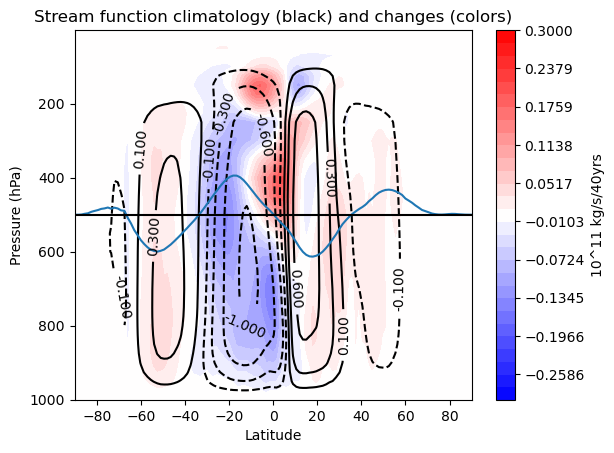

In [30]:
clima_strm = final_ds.strm_fnct.mean(['time'])

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')

contf = plt.contourf(lats, levels, trends_ds.strm_fnct_polyfit_coefficients.sel(degree=1) * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')

plt.colorbar(contf, label='10^11 kg/s/40yrs')

plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

#plt.axhline(700)
#plt.axvline(-12)

#plt.xlim([-50, 50])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.title('Stream function climatology (black) and changes (colors)')

plt.plot(lats, (final_ds.mmc_aht.mean('time') * 80 / 1e15) + 500)
plt.axhline(500, color='k')
#plt.savefig('../figures/aht_trends/merra_stream_function_clima_and_changes')

plt.show()

In [31]:
def trend(x):
    return x.polyfit('time', deg=1)

#Output is in W/ns, so we convert to PW/40yrs
merra_month = final_ds.groupby('time.month').mean('time')
merra_trends_month = final_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40

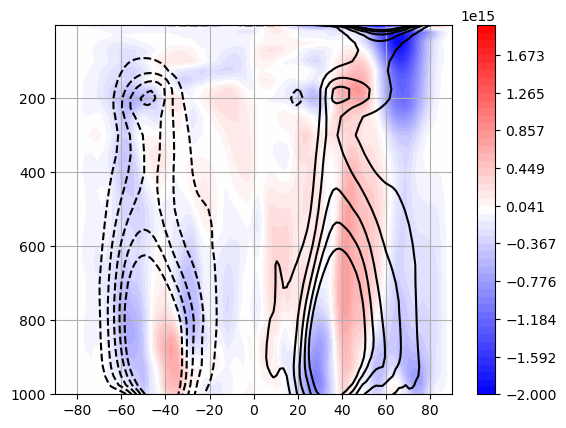

In [32]:
which_month = 2
te_tot = merra_month.VSEte + merra_month.VPEte + merra_month.VMEte
se_tot = merra_month.VSEse + merra_month.VPEse + merra_month.VMEse

eddy_tot = se_tot + te_tot

te_tot_trend = merra_trends_month.VSEte_polyfit_coefficients + merra_trends_month.VPEte_polyfit_coefficients + merra_trends_month.VMEte_polyfit_coefficients
se_tot_trend = merra_trends_month.VSEse_polyfit_coefficients + merra_trends_month.VPEse_polyfit_coefficients + merra_trends_month.VMEse_polyfit_coefficients

eddy_tot_trend = se_tot_trend + te_tot_trend

#plt.contour(lats, levels[::-1], te_tot.sel(month=which_month) * (weight[:,None]) * 1000 / (-weight[:,None] / g) / 1e15,
             #levels=[ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5], colors='k')

plt.contour(lats, levels, te_tot.sel(month=which_month) / 1e15,
             levels=[ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5], colors='k')

#plt.contourf(lats, levels[::-1], te_tot_trend.sel(degree=1).sel(month=which_month) * (weight[:,None]) * 1000 / (-weight[:,None] / g),
             #levels=np.linspace(-2e15, 2e15, 50), cmap='bwr')

plt.contourf(lats, levels, te_tot_trend.sel(degree=1).sel(month=which_month),
             levels=np.linspace(-2e15, 2e15, 50), cmap='bwr')
plt.colorbar()

plt.gca().invert_yaxis()

plt.grid()

plt.show()

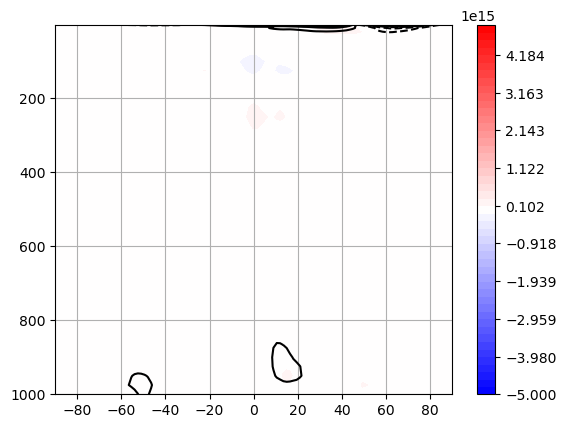

In [33]:
which_month = 2


mmc_month = merra_month.E_bar * merra_month.V_bar * ZON_WEIGHT
mmc_month_trend = merra_trends_month.E_bar_polyfit_coefficients * merra_trends_month.V_bar_polyfit_coefficients * ZON_WEIGHT


plt.contour(lats, levels, mmc_month.sel(month=which_month) * geometry[None,:] * g * 1000 / (-weight[:,None] / g) / 1e15,
             levels=[-50, -40, -30, -20, -10, 10, 20, 30 , 40, 50], colors='k')

plt.contourf(lats, levels, mmc_month_trend.sel(degree=1).sel(month=which_month) * geometry[None,:] * g * 1000 / (-weight[:,None] / g),
             levels=np.linspace(-5e15, 5e15, 50), cmap='bwr')

plt.colorbar()

plt.gca().invert_yaxis()

plt.grid()

plt.show()

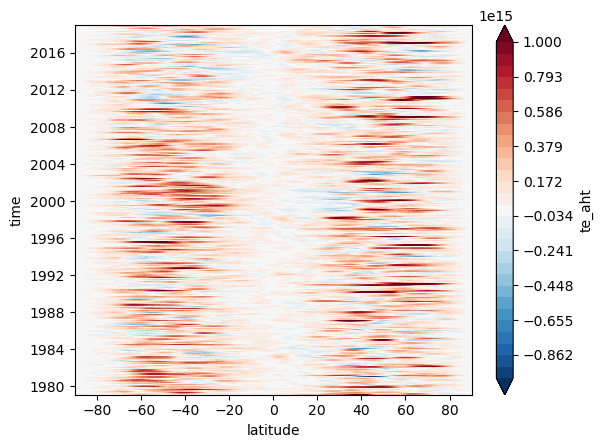

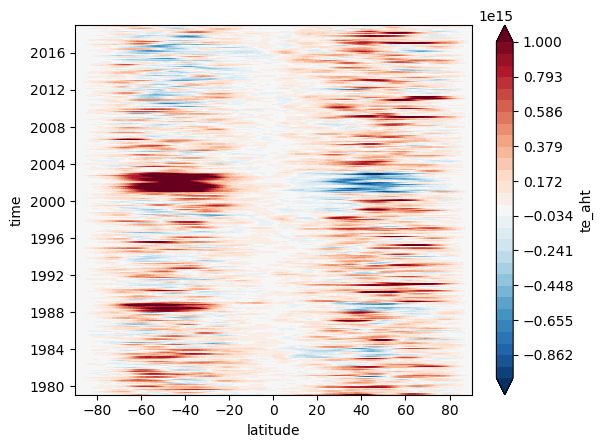

In [43]:
(final_ds.te_aht.groupby('time.month') - final_ds.te_aht.groupby('time.month').mean('time')).plot.contourf(levels=np.linspace(-1e15, 1e15, 30))

plt.show()

(old_ds.te_aht.groupby('time.month') - old_ds.te_aht.groupby('time.month').mean('time')).plot.contourf(levels=np.linspace(-1e15, 1e15, 30))

plt.show()

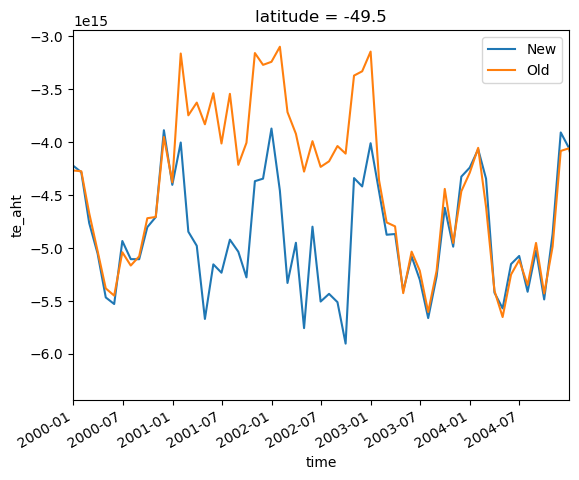

In [35]:
final_ds.te_aht.sel(latitude=-50, method='nearest').plot(label='New')
old_ds.te_aht.sel(latitude=-50, method='nearest').plot(label='Old')

plt.legend(loc=0)

plt.xlim(['2000-01-01', '2004-12-31'])
plt.show()

In [46]:
final_ds.te_aht.sel(latitude=-50, method='nearest').sel(time=slice('2004-01-01', '2017-12-31')).mean('time') - old_ds.te_aht.sel(latitude=-50, method='nearest').sel(time=slice('2004-01-01', '2017-12-31')).mean('time')




<xarray.DataArray 'te_aht' ()>
array(3.46192753e+13)
Coordinates:
    latitude  float64 -49.5

In [80]:
#final_ds.total_aht.sel(time=slice('2000-01-01', '2018-12-31')).mean('time').to_netcdf('merra2_total_aht_2000_2018.nc')

In [48]:
orig_ds = xr.open_dataset('merra_aht.nc')


orig_ds['total_aht_dry_pot'] = orig_ds.total_aht_dry + orig_ds.total_aht_pot
orig_ds['te_aht_dry_pot'] = orig_ds.te_aht_dry + orig_ds.te_aht_pot
orig_ds['se_aht_dry_pot'] = orig_ds.se_aht_dry + orig_ds.se_aht_pot
orig_ds['mmc_aht_dry_pot'] = orig_ds.mmc_aht_dry + orig_ds.mmc_aht_pot

orig_ds['eddy_aht'] = orig_ds.te_aht + orig_ds.se_aht
orig_ds['eddy_aht_dry'] = orig_ds.te_aht_dry + orig_ds.se_aht_dry
orig_ds['eddy_aht_moist'] = orig_ds.te_aht_moist + orig_ds.se_aht_moist
orig_ds['eddy_aht_pot'] = orig_ds.te_aht_pot + orig_ds.se_aht_pot
orig_ds['eddy_aht_dry_pot'] = orig_ds.te_aht_dry_pot + orig_ds.se_aht_dry_pot

final_ds['total_aht_dry_pot'] = final_ds.total_aht_dry + final_ds.total_aht_pot
final_ds['te_aht_dry_pot'] = final_ds.te_aht_dry + final_ds.te_aht_pot
final_ds['se_aht_dry_pot'] = final_ds.se_aht_dry + final_ds.se_aht_pot
final_ds['mmc_aht_dry_pot'] = final_ds.mmc_aht_dry + final_ds.mmc_aht_pot

final_ds['eddy_aht'] = final_ds.te_aht + final_ds.se_aht
final_ds['eddy_aht_dry'] = final_ds.te_aht_dry + final_ds.se_aht_dry
final_ds['eddy_aht_moist'] = final_ds.te_aht_moist + final_ds.se_aht_moist
final_ds['eddy_aht_pot'] = final_ds.te_aht_pot + final_ds.se_aht_pot
final_ds['eddy_aht_dry_pot'] = final_ds.te_aht_dry_pot + final_ds.se_aht_dry_pot

In [49]:
orig_trends = orig_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
new_trends = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

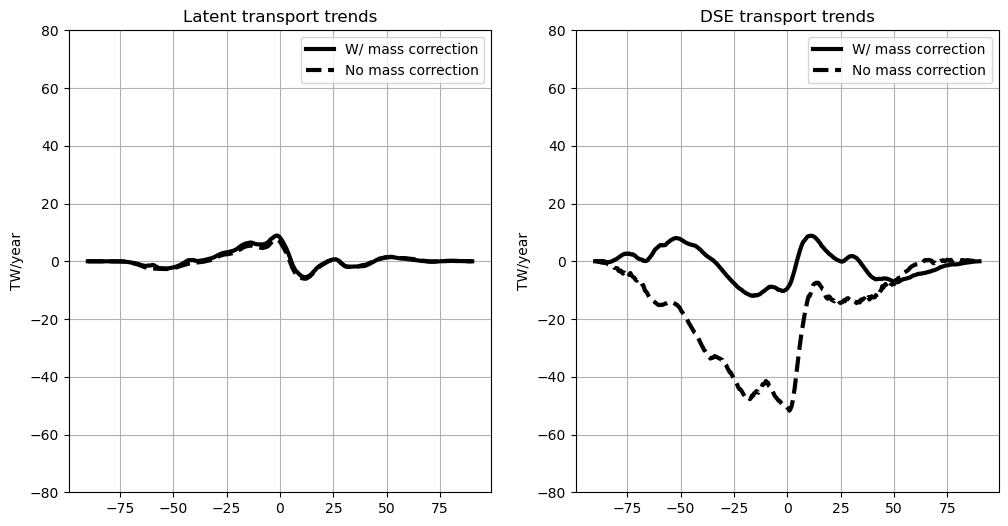

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(lats, (orig_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[0].plot(lats, (new_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[0].set_title('Latent transport trends')
axs[0].legend(loc=0)
axs[0].grid()
axs[0].set_ylabel('TW/year')
axs[0].set_ylim([-80, 80])

axs[1].plot(lats, (orig_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[1].plot(lats, (new_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[1].set_title('DSE transport trends')
axs[1].legend(loc=0)
axs[1].grid()
axs[1].set_ylabel('TW/year')
axs[1].set_ylim([-80, 80])

plt.show()